Modified from https://lectures.quantecon.org/jl/mccall_model.html and https://lectures.quantecon.org/jl/mccall_model_with_separation.html

# Some utility functions
These will be added to libraries in the future, so no needd to understand the details

In [1]:
using Parameters, NamedTuples, MacroTools

#Finds the fixed point of an operator.  This will be replaced by the NLsolve.jl based on at some point when it is functional.
function fixedpoint(f, x0; tol = 1E-10, maxiter=100)
    residual = Inf
    iter = 1
    xold = x0
    while residual > tol && iter < maxiter
        xnew = f(xold)        
        residual = norm(xold - xnew);
        xold = xnew
        iter += 1
    end
    return xold
end

#Generator for tuples with keyw
macro with_kw(args...)
    splits = map(args) do arg
        @match arg begin
            (a_ = b_) => (a, b)
            any_ => error("All arguments must be assignments")
        end
    end
    esc(:(
        (;$(map(splits) do pair
            Expr(:kw, pair[1], pair[2])
        end...),) -> 
        $NamedTuples.@NT($(map(splits) do pair
            Expr(:kw, pair[1], pair[1])
        end...))
    ))
end

@with_kw (macro with 1 method)

## Examples using `fixedpoint` and `@with_kw`

In [2]:
h(x) = 0.5 * x + 0.1
xstar = fixedpoint(h, 0.1)
@show h(xstar) - xstar

#Keyword generators
paramgenerator = @with_kw(a=10, b="test")
#Calling this returns a parameter with any defaults overwritten
@show paramgenerator() #i.e. all defaults
@show paramgenerator(a = 20);
@show paramgenerator(a = 20, b = "test3");

h(xstar) - xstar = 4.6566112077428556e-11
paramgenerator() = (a = 10, b = "test")
paramgenerator(a=20) = (a = 20, b = "test")
paramgenerator(a=20, b="test3") = (a = 20, b = "test3")


## Code to solve the McCall model

In [21]:
#Code to solve the mccall model
function solve_mccall_model(mcm; tol=1e-5, max_iter=2000, U_iv = 1.0, V_iv = ones(length(mcm.w)))
    #α, β, σ, c, γ, w = mcm.α, mcm.β, mcm.σ, mcm.c, mcm.γ, mcm.w
    @unpack α, β, σ, c, γ, w, p, u = mcm

    #Calculate the utility at the wages and unemployment
    u_w = u.(w, σ)
    u_c = u(c, σ)
    
    #Value function iteration
    # Setting up map T(x) -> x.  The fixed point is a x* such that T(x*) = x*
    function T(x) #Bellman operator
        V = x[1:end-1]
        U = x[end]
        return [u_w + β * ((1 - α) * V + α * U);
                u_c + β * (1 - γ) * U + β * γ * dot(max.(U, V), p)]        
    end
    
    x_iv = [V_iv;U_iv]; #Initial value to use for the fixed point
    
    xstar = fixedpoint(T, x_iv; tol = tol, maxiter=max_iter)    
    
    V = xstar[1:end-1]
    U = xstar[end]
    
    #Find the policy, where V > U  
    wbarindex = searchsortedfirst(V - U, 0.0)
    @show wbarindex
    if(wbarindex > length(w))
        wbar = Inf
    elseif(wbarindex < 0)
        wbar = -Inf
    else
        wbar = w[wbarindex]
    end
    return V, U, wbar
end
    
#Note: Can replace the T with the following equivalent,b ut more verbose version.
#     function T_verbose(x) #Bellman operator
#         V = x[1:end-1]
#         U = x[end]
#         Tx = similar(x) #Will fill in this as a new vector
#         for (i,wval) in enumerate(w)
#             Tx[i] = u(wval, σ) + β * ((1 - α) * V[i] + α * U); #For each wage
#         end
#         Tx[end] = u_c + β * (1 - γ) * U + β * γ * dot(max.(U, V), p) #For the search      
#         return Tx
#     end
#     xstar2 = fixedpoint(T_verbose, [V_iv;U_iv]; tol = tol, maxiter=max_iter)    
#     @show xstar ≈ xstar2

solve_mccall_model (generic function with 1 method)

## Parameters

In [22]:
using Plots, Distributions

#Wage values and distribution to use for probabilities.
n = 30
defaultw = linspace(10, 20, n)
dist = BetaBinomial(n - 1, 600, 400)
defaultp = pdf.(dist, support(dist))

#Generator for the named tuple to hold all parameters
mcm_defaults = @with_kw(
    u = (c,σ) -> (c.^(1 - σ) - 1) / (1 - σ),
    α = 0.2,
    β = 0.98,
    γ = 0.7,
    c = 6.0,
    σ = 2.0,
    w = defaultw,
    p = defaultp
)

(::#52) (generic function with 1 method)

## Using the solution method

wbarindex = 31
w_bar = Inf


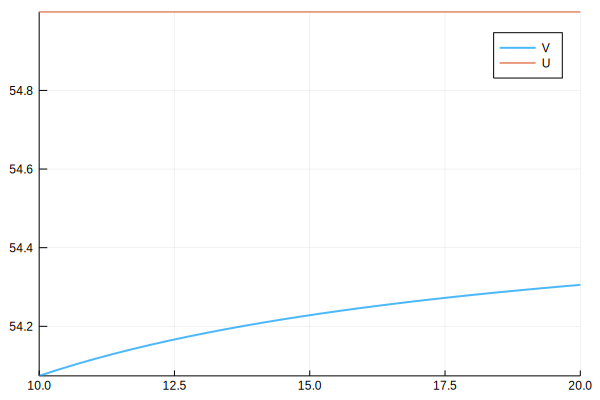

In [23]:
#Use the default parameters
mcm = mcm_defaults(c=-10.0)
V, U, w_bar = solve_mccall_model(mcm)
U_vec = U .* ones(mcm.w)
@show w_bar
plot(mcm.w, 
    [V U_vec],
    lw = 2, 
    α = 0.7, 
    label=["V" "U"])

## Comparative Statics with c

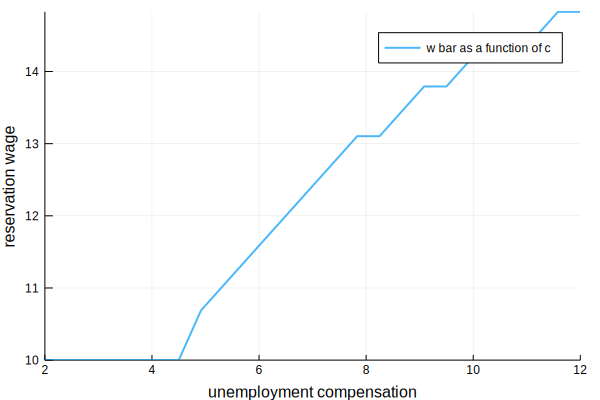

In [12]:
c_vals = linspace(2, 12, 25)  
w_bar_vals = similar(c_vals)

for (i, cval) in enumerate(c_vals)
    mcm = mcm_defaults(c = cval) #Solves the model changing the c.
    V, U, w_bar = solve_mccall_model(mcm)
    w_bar_vals[i] = w_bar
end

plot(c_vals, 
     w_bar_vals, 
     lw=2, 
     α=0.7, 
     xlabel="unemployment compensation",
     ylabel="reservation wage",
     label="w bar as a function of c")

## Comparative statics with γ

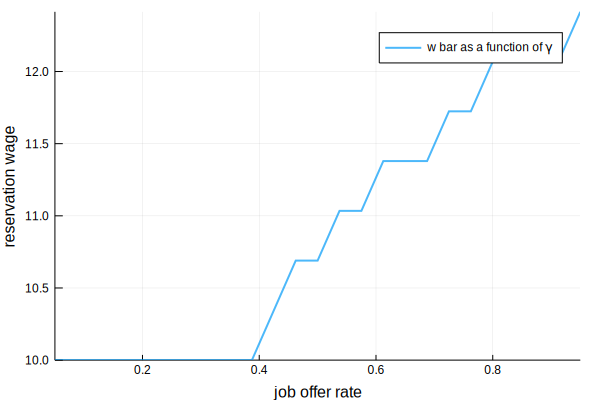

In [13]:
γ_vals = linspace(0.05, 0.95, 25)  
w_bar_vals = similar(γ_vals)

for (i, γ_val) in enumerate(γ_vals)
    mcm = mcm_defaults(γ = γ_val) #Solves the model changing the c.
    V, U, w_bar = solve_mccall_model(mcm)
    w_bar_vals[i] = w_bar
end


plot(γ_vals, 
     w_bar_vals, 
     lw=2, 
     α=0.7, 
     xlabel="job offer rate",
     ylabel="reservation wage",
     label="w bar as a function of \\gamma")